In [ ]:
######################################################################
## 06_ANALYSIS: Methylation vs. Gene Expression
######################################################################

### Note that any block starting with "SCRIPT" or "ON COMMAND LINE" should be run in terminal and not in notebook

In [1]:
######################################################################
## BLOCK 1: Load libraries
######################################################################

suppressMessages({
  library(bsseq)
  library(rtracklayer)
  library(GenomicRanges)
  library(tidyverse)
  library(tximport)
  library(ppcor)
  library(ggplot2)
  library(car)
  library(rstatix)
  library(forcats)
  library(purrr)
  library(broom)
  library(patchwork)
})

In [3]:
######################################################################
## BLOCK 2: Load Data and Metadata
######################################################################

load("bsseq_snp_masked.RData")
BSseq_obj <- BSseq_obj_masked

gff <- import("~/Mytilus/genome/ncbi_dataset/data/GCF_021869535.1/genomic.gff")
txi <- tximport("~/Mytilus-expression/salmon_quant/quant.sf", type = "salmon", txOut = TRUE)

# Extract gene-protein mapping from GFF
gff_df <- as.data.frame(gff)
tx2gene <- gff_df %>%
  filter(type == "CDS" & !is.na(protein_id) & !is.na(gene)) %>%
  distinct(protein_id, gene_id = gene)

# Process expression data
expression_df <- as.data.frame(txi$abundance) %>%
  rownames_to_column("tx_id") %>%
  pivot_longer(-tx_id, names_to = "sample", values_to = "tpm") %>%
  mutate(protein_id = str_extract(tx_id, "XP_\\d+\\.\\d+")) %>%
  left_join(tx2gene, by = "protein_id") %>%
  mutate(gene = paste0("gene-", gene_id)) %>%
  filter(!is.na(gene))

expression_gene <- expression_df %>%
  group_by(gene) %>%
  slice_max(tpm, n = 1) %>%
  summarise(tpm = sum(tpm), protein_id = first(protein_id), .groups = "drop")

## Load precomputed metagene methylation profile from notebook "Methylation across gene regions"
df_profile <- readRDS("~/Jupyter_Mytilus/df_profile.rds")

reading in files with read_tsv

1 




In [4]:
######################################################################
## BLOCK 3: Define Genomic Regions
######################################################################

genes_gr <- gff[gff$type == "gene" & !is.na(gff$gene), ]
genes_gr$gene <- paste0("gene-", genes_gr$gene)
names(genes_gr) <- genes_gr$gene

gene_bodies <- genes_gr
prox_promoters <- promoters(genes_gr, upstream = 150, downstream = 0)
names(prox_promoters) <- names(genes_gr)

In [5]:
######################################################################
## BLOCK 4: Calculate Average Methylation per Region
######################################################################

gene_meth <- getMeth(BSseq_obj, regions = gene_bodies, type = "raw", what = "perRegion") %>%
  as.data.frame() %>%
  mutate(gene = names(gene_bodies)) %>%
  relocate(gene)

prox_meth <- getMeth(BSseq_obj, regions = prox_promoters, type = "raw", what = "perRegion") %>%
  as.data.frame() %>%
  mutate(gene = names(prox_promoters)) %>%
  relocate(gene)

In [6]:
######################################################################
## BLOCK 5: Merge Expression + Methylation
######################################################################

gene_meth <- gene_meth %>% distinct(gene, .keep_all = TRUE)
prox_meth <- prox_meth %>% distinct(gene, .keep_all = TRUE)

meth_expr <- gene_meth %>%
  rename_with(~ paste0(.x, "_geneMeth"), .cols = -gene) %>%
  inner_join(prox_meth %>% rename_with(~ paste0(.x, "_proxMeth"), .cols = -gene), by = "gene") %>%
  inner_join(expression_gene, by = "gene") %>%
  mutate(expr_log = log10(tpm + 1))

In [7]:
######################################################################
## BLOCK 6: Partial Correlation and Interaction Model
######################################################################

sample_id <- "M50-24-1yr"
gene_col <- paste0(sample_id, "_geneMeth")
prom_col <- paste0(sample_id, "_proxMeth")

meth_expr <- meth_expr %>% mutate(
  promoter = .data[[prom_col]],
  gene_body = .data[[gene_col]]
)

# Drop missing
df <- meth_expr %>% drop_na(promoter, gene_body, expr_log)

# Partial correlations
cat("Partial correlation (expr ~ promoter | gene_body):\n")
print(pcor.test(df$expr_log, df$promoter, df["gene_body"], method = "spearman"))

cat("Partial correlation (expr ~ gene_body | promoter):\n")
print(pcor.test(df$expr_log, df$gene_body, df["promoter"], method = "spearman"))

# Linear model with interaction
model <- lm(expr_log ~ promoter * gene_body, data = df)
summary(model)

Partial correlation (expr ~ promoter | gene_body):
    estimate      p.value statistic     n gp   Method
1 -0.1170058 2.356598e-64 -16.99683 20816  1 spearman
Partial correlation (expr ~ gene_body | promoter):
   estimate p.value statistic     n gp   Method
1 0.5227662       0  88.46931 20816  1 spearman



Call:
lm(formula = expr_log ~ promoter * gene_body, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3869 -0.2506 -0.1944  0.1802  4.1501 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.242939   0.005006  48.525   <2e-16 ***
promoter            0.028869   0.086416   0.334    0.738    
gene_body           1.143959   0.014585  78.435   <2e-16 ***
promoter:gene_body -1.354457   0.163310  -8.294   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5489 on 20812 degrees of freedom
Multiple R-squared:  0.2294,	Adjusted R-squared:  0.2293 
F-statistic:  2065 on 3 and 20812 DF,  p-value: < 2.2e-16


In [8]:
######################################################################
## BLOCK 7: Categorize Methylation Pattern
######################################################################

meth_expr <- meth_expr %>% mutate(
  pattern = case_when(
    promoter < 0.1 & gene_body > 0.1 ~ "Low Promoter / High Gene Body",
    promoter > 0.1 & gene_body < 0.1 ~ "High Promoter / Low Gene Body",
    promoter > 0.1 & gene_body > 0.1 ~ "High Promoter / High Gene Body",
    promoter < 0.1 & gene_body < 0.1 ~ "Low Promoter / Low Gene Body",
    TRUE ~ NA_character_
  ),
  expr_bin = cut(expr_log, breaks = c(-Inf, 0.5, 1, 2, Inf),
                 labels = c("Low", "Medium", "High", "Very High"))
)

In [13]:
######################################################################
## BLOCK 8A: Methylation–Expression Figure and Gene Counts Figure
######################################################################

# Define consistent levels for all pattern labels
pattern_levels <- c(
  "Low Promoter / Low Gene Body",
  "Low Promoter / High Gene Body",
  "High Promoter / Low Gene Body",
  "High Promoter / High Gene Body"
)

pattern_labels <- c(
  "Low Promoter\nLow Gene Body",
  "Low Promoter\nHigh Gene Body",
  "High Promoter\nLow Gene Body",
  "High Promoter\nHigh Gene Body"
)

meth_expr <- meth_expr %>%
  mutate(
    pattern = factor(pattern, levels = pattern_levels),
    pattern_label = case_when(
      pattern == "Low Promoter / Low Gene Body"   ~ "Low Promoter\nLow Gene Body",
      pattern == "Low Promoter / High Gene Body"  ~ "Low Promoter\nHigh Gene Body",
      pattern == "High Promoter / Low Gene Body"  ~ "High Promoter\nLow Gene Body",
      pattern == "High Promoter / High Gene Body" ~ "High Promoter\nHigh Gene Body",
      TRUE ~ NA_character_
    ),
    pattern_label = factor(pattern_label, levels = pattern_labels)
  )

# --- Gene Count Panel ---
plot_counts <- meth_expr %>%
  filter(!is.na(pattern_label)) %>%
  count(pattern_label) %>%
  ggplot(aes(y = pattern_label, x = n, fill = pattern_label)) +
  geom_bar(stat = "identity", color = "black", width = 0.8, alpha = 0.8) +
  scale_fill_brewer(palette = "Set2", guide = "none") +
  theme_minimal(base_size = 15) +
  scale_x_continuous(labels = scales::label_number(scale_cut = scales::cut_short_scale())) +
  labs(x = "Gene Count", y = NULL) +
  theme(
    axis.text.y = element_text(size = 13, lineheight = 0.9),
    plot.margin = margin(40, 10, 10, 10),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


# --- Violin Panel  ---
plot_violin <- meth_expr %>%
  filter(!is.na(pattern_label)) %>%
  ggplot(aes(x = pattern_label, y = expr_log, fill = pattern_label)) +
  geom_jitter(width = 0.2, size = 0.3, alpha = 0.2, color = "black") +
  geom_violin(trim = FALSE, alpha = 0.8, scale = "width", width = 1.2, color = "black") +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "white", color = "black") +
  coord_flip(clip = "on") +
  ylim(-0.5, 3.5) +
  theme_minimal(base_size = 15) +
  labs(x = NULL, y = "Log10(Expression + 1)") +
  scale_fill_brewer(palette = "Set2", guide = "none") +
  theme(
    axis.text.y = element_blank(),
    axis.title.y = element_blank(),
    legend.position = "none",
    plot.margin = margin(10, 20, 10, 0)
  )



In [14]:
######################################################################
## BLOCK 8B: Print Counts
######################################################################

library(dplyr)
library(glue)

# Ensure your pattern levels exist (same as in your plotting block)
pattern_levels <- c(
  "Low Promoter / Low Gene Body",
  "Low Promoter / High Gene Body",
  "High Promoter / Low Gene Body",
  "High Promoter / High Gene Body"
)

# If meth_expr may contain multiple rows per gene, deduplicate on gene_id if present
df <- meth_expr %>%
  filter(!is.na(pattern)) %>%
  { if ("gene_id" %in% names(.)) distinct(., gene_id, .keep_all = TRUE) else . } %>%
  mutate(pattern = factor(pattern, levels = pattern_levels))

# Counts by category
counts <- df %>%
  count(pattern, name = "n")

# Helper to pull counts safely
get_n <- function(cat) {
  x <- counts$n[counts$pattern == cat]
  if (length(x) == 0) 0L else x
}

n_low_low   <- get_n("Low Promoter / Low Gene Body")
n_low_high  <- get_n("Low Promoter / High Gene Body")
n_high_low  <- get_n("High Promoter / Low Gene Body")
n_high_high <- get_n("High Promoter / High Gene Body")

n_highGB     <- n_low_high + n_high_high            # all gene-body–methylated genes
total_genes  <- sum(counts$n)

# Optional formatting with thousands separators for prose
fmt <- function(x) format(x, big.mark = ",", scientific = FALSE)

# Compact table for the manuscript or supplement
counts_tbl <- tibble::tibble(
  Category = c(
    "Low Promoter / Low Gene Body",
    "Low Promoter / High Gene Body",
    "High Promoter / Low Gene Body",
    "High Promoter / High Gene Body",
    "Gene-body methylated (High Gene Body)",
    "Total"
  ),
  N = c(n_low_low, n_low_high, n_high_low, n_high_high, n_highGB, total_genes),
  Proportion = round(c(n_low_low, n_low_high, n_high_low, n_high_high, n_highGB, total_genes) / total_genes, 3)
)

print(counts_tbl)

# Guardrails
stopifnot(sum(counts$n) == nrow(df))

# A tibble: 6 × 3
  Category                                  N Proportion
  <chr>                                 <int>      <dbl>
1 Low Promoter / Low Gene Body          11858      0.57 
2 Low Promoter / High Gene Body          8174      0.393
3 High Promoter / Low Gene Body            84      0.004
4 High Promoter / High Gene Body          692      0.033
5 Gene-body methylated (High Gene Body)  8866      0.426
6 Total                                 20808      1    


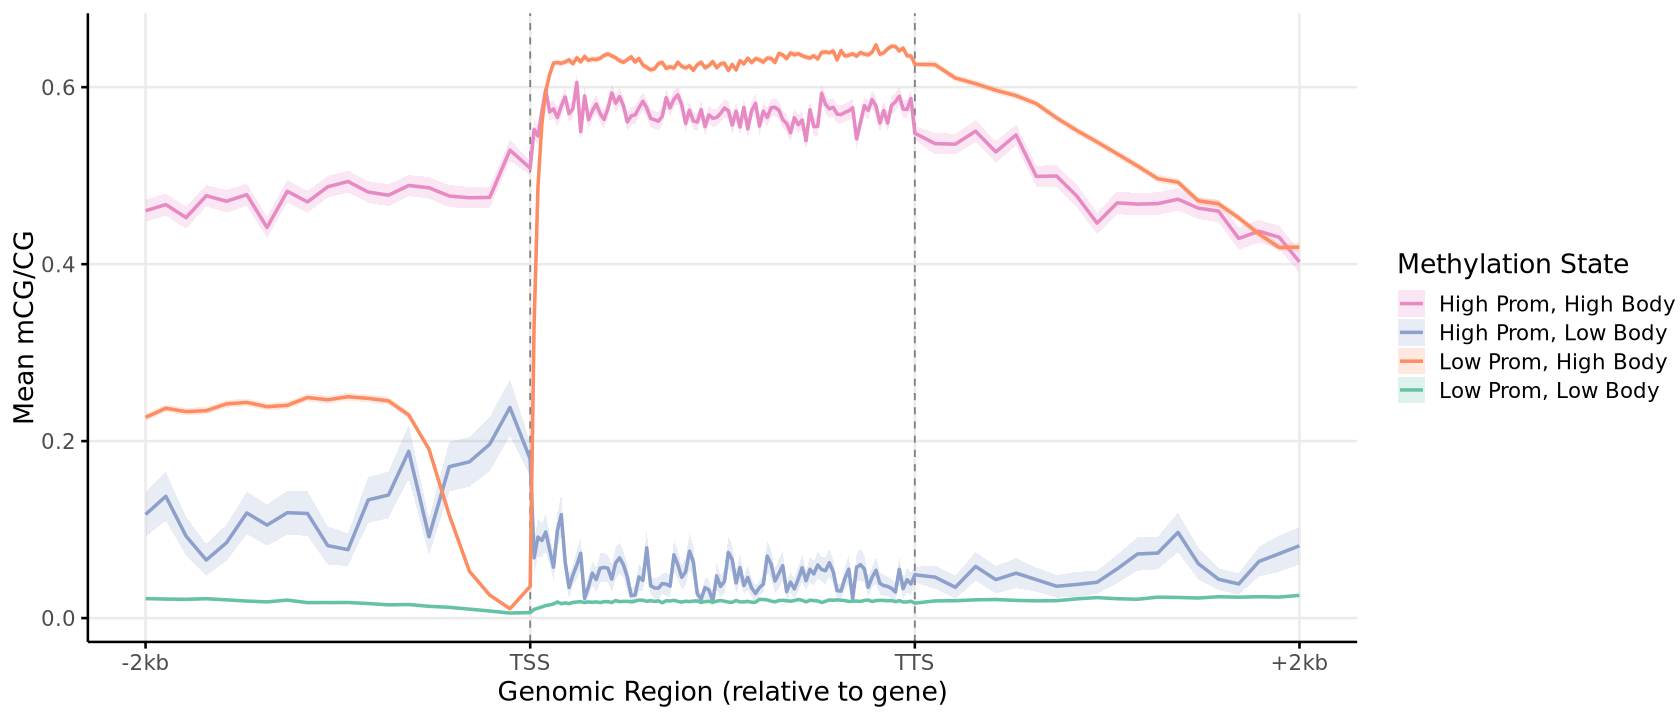

In [15]:
######################################################################
## BLOCK 9: Plot Metagene Profiles by Methylation State
######################################################################

# Step 1: Summarize gene-level methylation
gene_meth_summary <- meth_expr %>%
  transmute(
    gene_id = gene,
    proxMeth = rowMeans(select(., ends_with("_proxMeth")), na.rm = TRUE),
    geneMeth = rowMeans(select(., ends_with("_geneMeth")), na.rm = TRUE)
  )

# Step 2: Merge with df_profile and assign pattern labels
df_plot <- df_profile %>%
  left_join(gene_meth_summary, by = "gene_id") %>%
  mutate(
    pattern_named = case_when(
      proxMeth >= 0.1 & geneMeth < 0.1  ~ "Initiation Blocked",
      proxMeth >= 0.1 & geneMeth >= 0.1 ~ "Silenced",
      proxMeth < 0.1  & geneMeth >= 0.1 ~ "Transcription Competent",
      proxMeth < 0.1  & geneMeth < 0.1  ~ "Unmarked",
      TRUE ~ NA_character_
    ),
    pattern_state = case_when(
      pattern_named == "Initiation Blocked"      ~ "High Prom, Low Body",
      pattern_named == "Silenced"                ~ "High Prom, High Body",
      pattern_named == "Transcription Competent" ~ "Low Prom, High Body",
      pattern_named == "Unmarked"                ~ "Low Prom, Low Body",
      TRUE ~ NA_character_
    ),
    pattern_state = factor(
      pattern_state,
      levels = c("Low Prom, Low Body", "Low Prom, High Body", 
                 "High Prom, Low Body", "High Prom, High Body")
    )
  )

# Step 3: Add relative position for x-axis (in kb)
nbins_flank <- 20
nbins_body  <- 100
total_bins  <- nbins_body + 2 * nbins_flank

x_pos_kb <- c(
  seq(-2, 0, length.out = nbins_flank),
  seq(0, 2, length.out = nbins_body),
  seq(2, 4, length.out = nbins_flank)
)

bin_position_df <- tibble(bin_global = 1:total_bins, x_kb = x_pos_kb)

df_plot_joined <- df_plot %>%
  inner_join(bin_position_df, by = "bin_global")

# Step 4: Force drawing order by splitting and rebinding manually
plot_data <- df_plot_joined %>%
  filter(!is.na(pattern_state), !is.nan(methylation)) %>%
  group_by(pattern_state, x_kb) %>%
  summarise(
    mean_meth = mean(methylation, na.rm = TRUE),
    sem_meth  = sd(methylation, na.rm = TRUE) / sqrt(n()),
    .groups   = "drop"
  )

# Draw order: bottom → top
draw_order <- c(
  "High Prom, High Body", # pink
  "High Prom, Low Body",
  "Low Prom, High Body",
  "Low Prom, Low Body"
)

color_values <- c(
  "High Prom, High Body" = "#e78ac3",
  "High Prom, Low Body"  = "#8da0cb",
  "Low Prom, High Body"  = "#fc8d62",
  "Low Prom, Low Body"   = "#66c2a5"
)

# Base plot with axis and labels
plot_state_metagene <- ggplot() +
  geom_vline(xintercept = c(0, 2), linetype = "dashed", color = "gray50") +
  scale_x_continuous(
    breaks = c(-2, 0, 2, 4),
    labels = c("-2kb", "TSS", "TTS", "+2kb")
  ) +
  labs(
    x = "Genomic Region (relative to gene)",
    y = "Mean mCG/CG",
    color = "Methylation State",
    fill  = "Methylation State"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0, face = "bold"),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "black"),
    axis.ticks = element_line(color = "black")
  )

# Add layers one by one (bottom to top)
for (state in draw_order) {
  df <- filter(plot_data, pattern_state == state)
  plot_state_metagene <- plot_state_metagene +
    geom_ribbon(data = df,
                aes(x = x_kb, ymin = mean_meth - sem_meth, ymax = mean_meth + sem_meth,
                    fill = pattern_state),
                alpha = 0.2, color = NA) +
    geom_line(data = df,
              aes(x = x_kb, y = mean_meth, color = pattern_state),
              size = 1)
}

# Add manual color scales
plot_state_metagene <- plot_state_metagene +
  scale_color_manual(values = color_values) +
  scale_fill_manual(values = color_values)

options(repr.plot.width = 14, repr.plot.height = 6)

# Show the plot
plot_state_metagene

Warning message:
“Removed 39 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 39 rows containing non-finite outside the scale range (`stat_summary()`).”
Warning message:
“`position_dodge()` requires non-overlapping x intervals.”
Warning message:
“Removed 39 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 49 rows containing missing values or values outside the scale range (`geom_violin()`).”
Warning message:
“Removed 39 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 39 rows containing non-finite outside the scale range (`stat_summary()`).”
Warning message:
“`position_dodge()` requires non-overlapping x intervals.”
Warning message:
“Removed 39 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 49 rows containing missing values or values outside the scale range (`geom_v

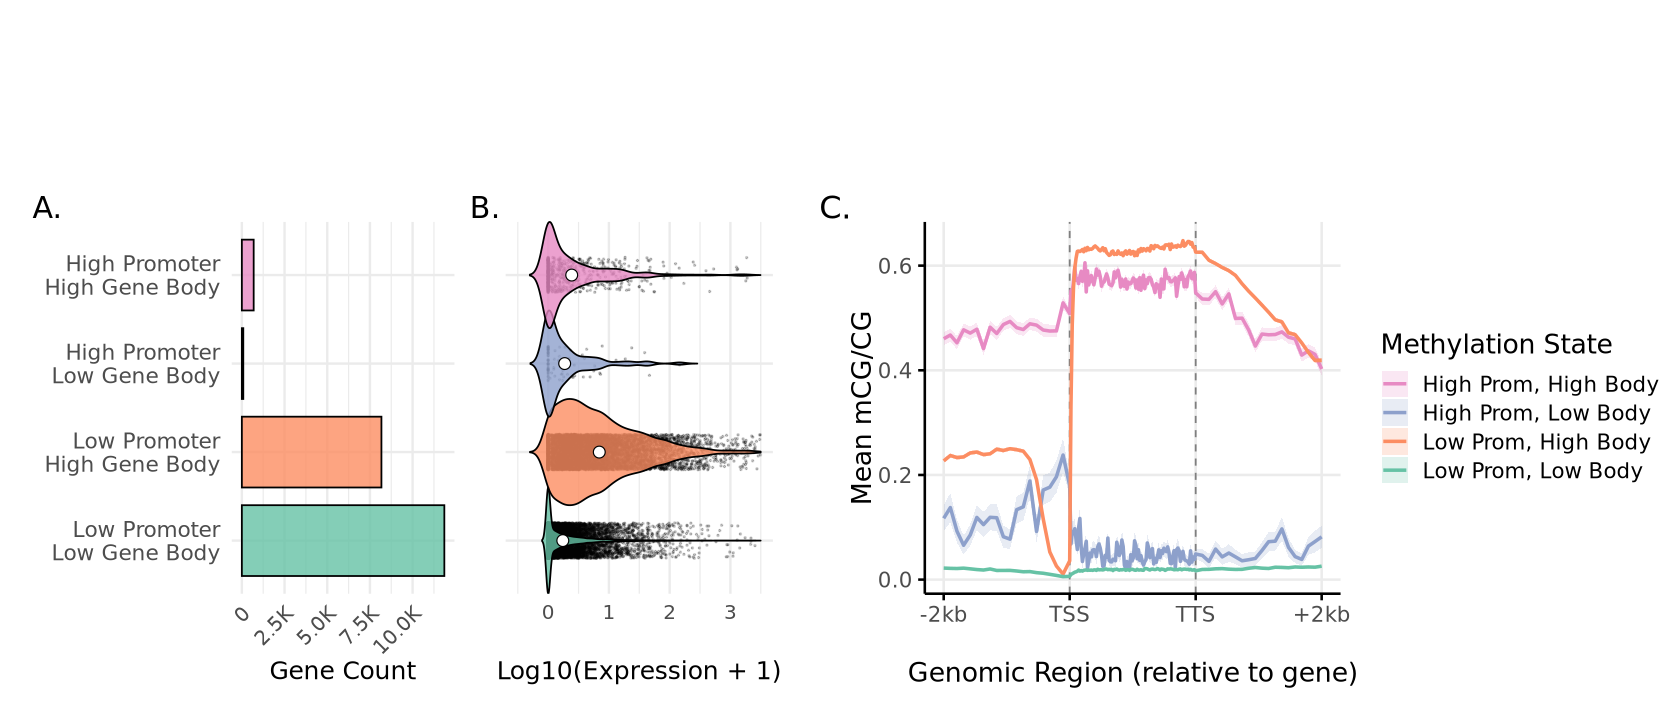

In [17]:
######################################################################
## BLOCK 10: Combine Expression Panels with Metagene Profile
######################################################################

library(patchwork)

# New top row: Gene count, violin, metagene profile (no proportion panel)
top_row <- plot_counts + plot_violin + plot_state_metagene +
  plot_layout(widths = c(1.5, 1.8, 2.8))

# Add a top spacer row to push panel letters down
combined_plot <- plot_spacer() / top_row +
  plot_layout(heights = c(0.2, 1)) +
  plot_annotation(
    tag_levels = "A",
    tag_suffix = ".",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
      plot.margin = margin(t = 20, r = 10, b = 10, l = 10)
    )
  )

# Display
combined_plot

ggsave(
  "Fig3.pdf",
  combined_plot,
  width = 12, height = 5,   # adjust as needed
  units = "in"
)